# Generate inclusion burden map for a sample slide

In [1]:
# Prelims
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import json
import copy
import torch.cuda as cutorch
import timeit
import scipy.special
import sys
import openslide
from scipy.ndimage import gaussian_filter

# Import modified wildcat
sys.path.append("wildcat.pytorch")
sys.path.append("../wildcat.pytorch")
sys.path.append("../")
import wildcat.models
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.13.1+cu117
Torchvision Version:  0.14.1+cu117
CUDA status:  True
CUDA memory max alloc:        0 MB


## Experiment Setup

In [2]:
# Set the experiment directory
# exp_dir = "/home/pauly2/cndr_histo/data/phf1/samples/exp03"
exp_dir = "/data/pauly2/wildcat/data/thon2019/exp02_multiclass"

# Set the WSI file to process
# wsi_file = "/home/pauly2/cndr_histo/scratch2/2013-223-15F_L_HIP_AT8_1K_02-01-21_WT.svs"
# wsi_file = "/home/pauly2/cndr_histo/scratch2/mrxs/2021-209 hipp phf1.mrxs"
wsi_file = "/data/pauly2/wildcat/data/HNL-32-18_HR2a_TAU_12.tif"

# Size of the training patch used to train wildcat, in raw pixels
patch_size_raw = 224

# Size of the window used to apply WildCat. Should be larger than the patch size
# This does not include the padding
window_size_raw = 2240

## Load Configuration and Models

In [3]:
# Set main directories
data_dir = os.path.join(exp_dir, "patches")
model_dir = os.path.join(exp_dir, "models")

# Load model configuration from config.json
with open(os.path.join(model_dir, 'config.json'), 'r') as jfile:
    config = json.load(jfile)

# Set global properties
num_classes=config['num_classes']
input_size=config['wildcat_upsample']['input_size']
batch_size=config['wildcat_upsample']['batch_size']

In [4]:
# Create the model
model_ft=resnet50_wildcat_upsample(
    config['num_classes'], 
    pretrained=True, 
    kmax=config['wildcat_upsample']['kmax'], 
    kmin=config['wildcat_upsample']['kmin'],
    alpha=config['wildcat_upsample']['alpha'], 
    num_maps=config['wildcat_upsample']['num_maps'])

# Read model state
#model_ft.load_state_dict(
#    torch.load(os.path.join(model_dir, "wildcat_upsample.dat")))

# model_ft.load_state_dict(torch.load(os.path.join(model_dir, "wildcat_upsample.dat")))
model_ft.load_state_dict(torch.load(os.path.join(model_dir, "wildcat_bbox_celoss.dat")))

# Send model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Sending loaded model to device: ", device)
model_ft.eval()
model_ft = model_ft.to(device)

/home/pauly2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/pauly2/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sending loaded model to device:  cuda:0


In [5]:
model_dir

'/data/pauly2/wildcat/data/thon2019/exp02_multiclass/models'

## Load WSI

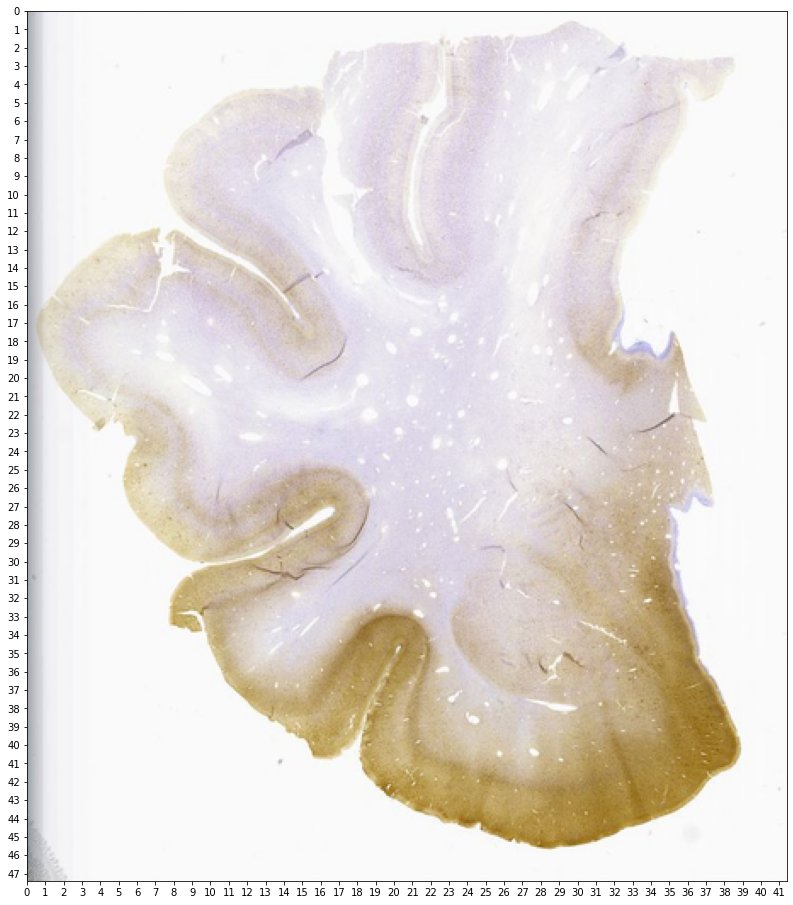

In [6]:
# Read a slide and show thumbnail
osl=openslide.OpenSlide(wsi_file)
plt.figure(figsize=(16,16))
plt.imshow(osl.get_thumbnail((512,512)), 
           extent=(0,osl.level_dimensions[0][0]/window_size_raw,osl.level_dimensions[0][1]/window_size_raw,0))
ax = plt.gca()
plt.xticks(np.arange(0,osl.level_dimensions[0][0]/window_size_raw));
plt.yticks(np.arange(0,osl.level_dimensions[0][1]/window_size_raw));

## Generate burden map
To speed this up, you can specify a sub-range of pixels to process

In [7]:
# u_range,v_range = None,None
u_range,v_range = (28,32),(40,44)
# u_range,v_range = (18,23),(38,43)

In [8]:
# The amount of padding, relative to patch size to add to the window. This padding
# is to provide context at the edges of the window
padding_size_rel = 1.0
padding_size_raw = int(padding_size_rel * patch_size_raw)

# Dimensions of the input image
slide_dim = np.array(osl.dimensions)

# Factor by which wildcat shrinks input images when mapping to segmentations
wildcat_shrinkage=2

# Additional shrinkage to apply to output (because we don't want to store very large)
# output images
extra_shrinkage=2

# Size of output pixel (in input pixels)
out_pix_size = wildcat_shrinkage * extra_shrinkage * patch_size_raw * 1.0 / input_size

# The output size for each window
window_size_out = int(window_size_raw / out_pix_size)

# The padding size for the output
padding_size_out = int(padding_size_rel * patch_size_raw / out_pix_size)

# Total number of non-overlapping windows to process
n_win = np.ceil(slide_dim / window_size_raw).astype(int)

# Output image size 
out_dim=(n_win * window_size_out).astype(int)

# Output array (last dimension is per-class probabilities)
density=np.zeros((num_classes, out_dim[0], out_dim[1]))

# Range of pixels to scan
u_range = (0,n_win[0]) if u_range is None else u_range
v_range = (0,n_win[1]) if v_range is None else v_range

# Range non-overlapping windows
t_00 = timeit.default_timer()
for u in range(u_range[0], u_range[1]):
    for v in range(v_range[0], v_range[1]):
        
        # Get the coordinates of the window in raw pixels
        x,y,w = u*window_size_raw,v*window_size_raw,window_size_raw
        
        # Subtract the padding
        xp,yp,wp = x-padding_size_raw,y-padding_size_raw,window_size_raw+2*padding_size_raw
        
        # Read the chunk from the image
        t0 = timeit.default_timer()
        chunk_img=osl.read_region((xp,yp), 0, (wp,wp)).convert("RGB")
        t1 = timeit.default_timer()
                
        # Compute the desired size of input to wildcat
        wwc = int(wp * input_size / patch_size_raw)

        # Resample the chunk for the two networks
        tran = transforms.Compose([
            transforms.Resize((wwc,wwc)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        # Convert the read chunk to tensor format
        with torch.no_grad():
            
            # Apply transforms and turn into correct-size torch tensor
            chunk_tensor=torch.unsqueeze(tran(chunk_img),dim=0).to(device)
            
            # Forward pass through the wildcat model
            x_clas = model_ft.forward_to_classifier(chunk_tensor)
            x_cpool = model_ft.spatial_pooling.class_wise(x_clas)

            # Scale the cpool image to desired size
            x_cpool_up = torch.nn.functional.interpolate(x_cpool, scale_factor=1.0/extra_shrinkage).detach().cpu().numpy()

            # Extract the central portion of the output
            p0,p1 = padding_size_out,(padding_size_out+window_size_out)
            x_cpool_ctr = x_cpool_up[:,:,p0:p1,p0:p1]
            
            # Stick it into the output array
            xout0,xout1 = u * window_size_out, ((u+1) * window_size_out)
            yout0,yout1 = v * window_size_out, ((v+1) * window_size_out)
            for i in range(num_classes):
                density[i,xout0:xout1,yout0:yout1] = x_cpool_ctr[0,i,:,:].transpose()
                
        # Finished first pass through the chunk
        t2 = timeit.default_timer()
        
        # At this point we have a list of hits for this chunk
        print("Chunk: (%6d,%6d) Times: IO=%6.4f WldC=%6.4f Totl=%8.4f" %
              (u,v,t1-t0,t2-t1,t2-t0))
        
# Trim the density array to match size of input
out_dim_trim=np.round((slide_dim/out_pix_size)).astype(int)
density=density[:,0:out_dim_trim[0],0:out_dim_trim[1]]

# Take the softmax of the density along the zero dimension
# density_softmax=scipy.special.softmax(density, axis=0)

Chunk: (    28,    40) Times: IO=0.1800 WldC=1.4097 Totl=  1.5896
Chunk: (    28,    41) Times: IO=0.1881 WldC=0.4272 Totl=  0.6153
Chunk: (    28,    42) Times: IO=0.1891 WldC=0.4412 Totl=  0.6304
Chunk: (    28,    43) Times: IO=0.1971 WldC=0.4236 Totl=  0.6207
Chunk: (    29,    40) Times: IO=0.1818 WldC=0.4297 Totl=  0.6115
Chunk: (    29,    41) Times: IO=0.1910 WldC=0.4176 Totl=  0.6086
Chunk: (    29,    42) Times: IO=0.1835 WldC=0.4396 Totl=  0.6231
Chunk: (    29,    43) Times: IO=0.1872 WldC=0.4177 Totl=  0.6050
Chunk: (    30,    40) Times: IO=0.1828 WldC=0.4375 Totl=  0.6203
Chunk: (    30,    41) Times: IO=0.1907 WldC=0.4262 Totl=  0.6169
Chunk: (    30,    42) Times: IO=0.1838 WldC=0.4339 Totl=  0.6177
Chunk: (    30,    43) Times: IO=0.1865 WldC=0.4222 Totl=  0.6087
Chunk: (    31,    40) Times: IO=0.2005 WldC=0.4368 Totl=  0.6373
Chunk: (    31,    41) Times: IO=0.1882 WldC=0.4242 Totl=  0.6125
Chunk: (    31,    42) Times: IO=0.1819 WldC=0.4401 Totl=  0.6220
Chunk: (  

In [9]:
# A function to plot a region of the histology image and corresponding tangle prediction
def plot_classification_region(u0,v0,u1,v1,d_sample,fg_class=1,vrange=(0, 1),sigma=0,show_ticks=True):
    # The image region
    img_rgn=osl.read_region((u0,v0), d_sample,
                            (int((u1-u0)/osl.level_downsamples[d_sample]),
                             int((v1-v0)/osl.level_downsamples[d_sample])))
    
    # The tangle map
    o_u0 = int(u0 / out_pix_size)
    o_v0 = int(v0 / out_pix_size)
    o_u1 = int(u1 / out_pix_size)
    o_v1 = int(v1 / out_pix_size)
    # t_map=(2 * density[fg_class,o_u0:o_u1,o_v0:o_v1] - density[:,o_u0:o_u1,o_v0:o_v1].sum(axis=0)).transpose()
    # density[1,o_u0:o_u1,o_v0:o_v1].transpose()-density[0,o_u0:o_u1,o_v0:o_v1].transpose()
    # t_map=np.where(t_map > 0, t_map, 0)
    
    # Commented out in 2023-02-16 - wanna look at raw maps with the new loss
    # t_map=density_softmax[fg_class, o_u0:o_u1,o_v0:o_v1].transpose()
    # t_map=np.where(t_map > 1.0/num_classes, t_map, 1.0/num_classes)
    
    t_map = density[fg_class, o_u0:o_u1,o_v0:o_v1].transpose()
    
    # Smooth the tangle map
    t_map = gaussian_filter(t_map, sigma)
    
    # Create plots side by side
    fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(20,10))
    
    # Plot the image region
    ax[0].imshow(img_rgn, extent=(u0,u1,v1,v0))
    ax[0].grid(color='black', linestyle='-', linewidth=0.5)
    cs=ax[1].imshow(t_map, plt.get_cmap("jet"), vmin=vrange[0], vmax=vrange[1], extent=(u0,u1,v1,v0))
    ax[0].set_title('Image Patch')
    ax[1].grid(color='black', linestyle='-', linewidth=0.5)
    label = list(config['class_to_idx'].keys())[list(config['class_to_idx'].values()).index(fg_class)]
    ax[1].set_title('Class %s Density Softmax' % (label,))
    # ax[1].colorbar(cs)
    if show_ticks is False:
        ax[0].xaxis.set_ticklabels([])
        ax[1].xaxis.set_ticklabels([])
        ax[0].yaxis.set_ticklabels([])
        ax[1].yaxis.set_ticklabels([])
    fig.show()

# Visualize burden map

In [29]:
# plot_classification_region(7500,5000,42500,40000,2,(-3,3),10, show_ticks=True)
plot_classification_region(0,0,slide_dim[0],slide_dim[1],2,fg_class=1,sigma=2)
# plot_classification_region(u_range[0]*window_size_raw,v_range[0]*window_size_raw,u_range[1]*window_size_raw,v_range[1]*window_size_raw,6,
#                           fg_class=3,sigma=2)

KeyboardInterrupt: 

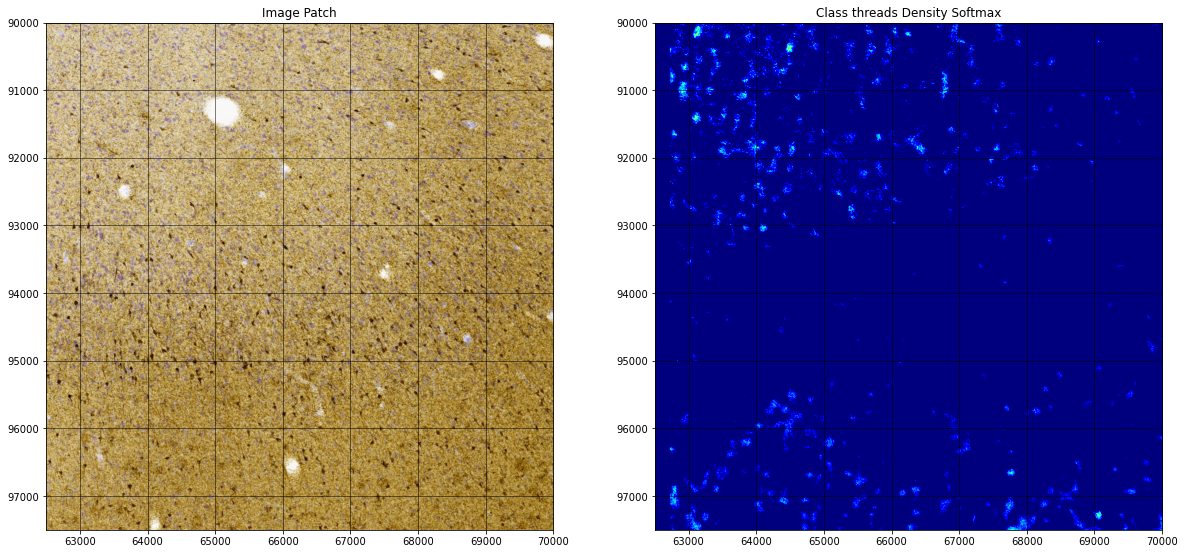

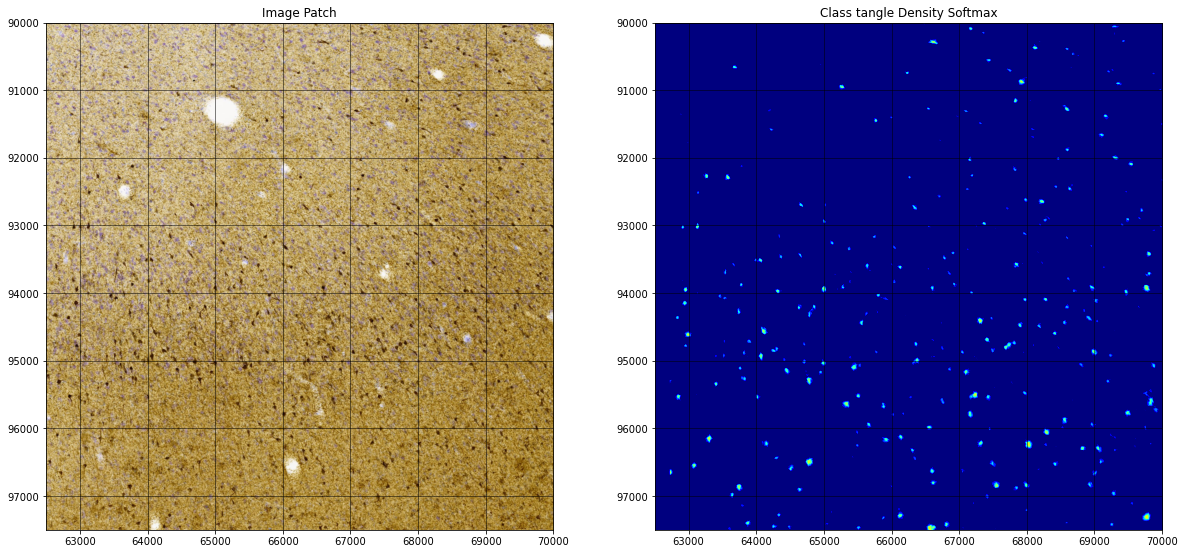

In [10]:
plot_classification_region(62500,90000,70000,97500,2,fg_class=3,sigma=0.5,show_ticks=True, vrange=(0, 6))
plot_classification_region(62500,90000,70000,97500,2,fg_class=2,sigma=0.5,show_ticks=True, vrange=(0, 6))
# plot_classification_region(40000,86000,42000,88000,0,fg_class=3,sigma=2,show_ticks=True)

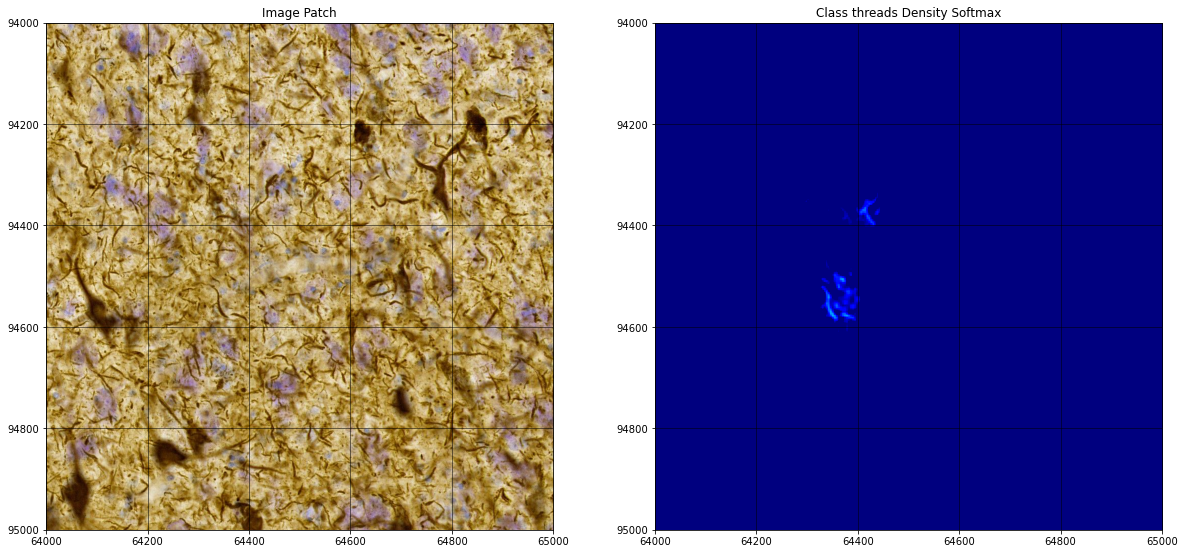

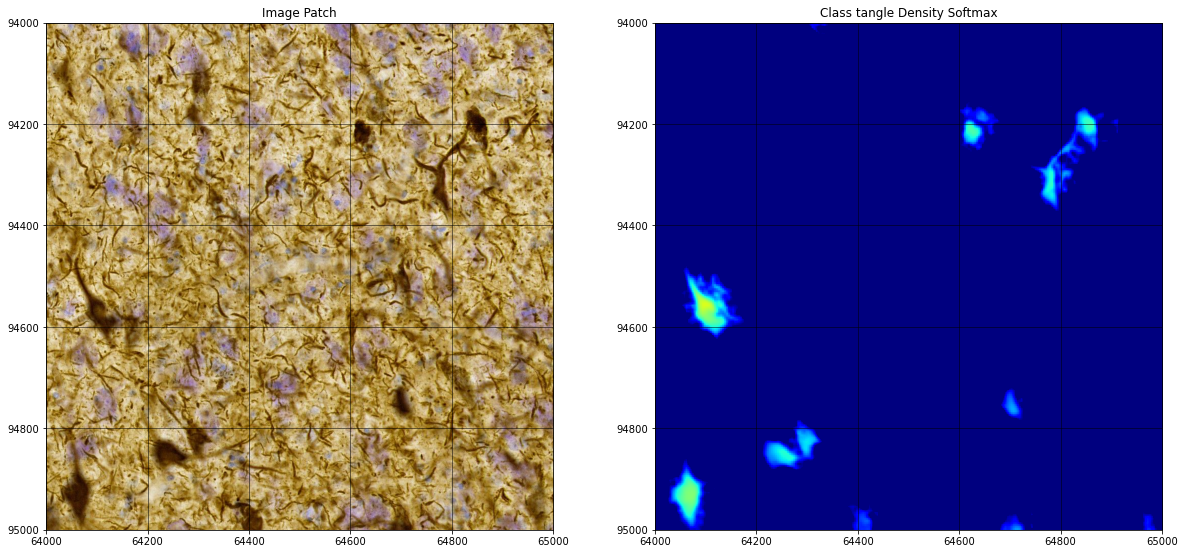

In [12]:
plot_classification_region(64000,94000,65000,95000,0,fg_class=3,show_ticks=True, vrange=(0, 6))
plot_classification_region(64000,94000,65000,95000,0,fg_class=2,show_ticks=True, vrange=(0, 6))

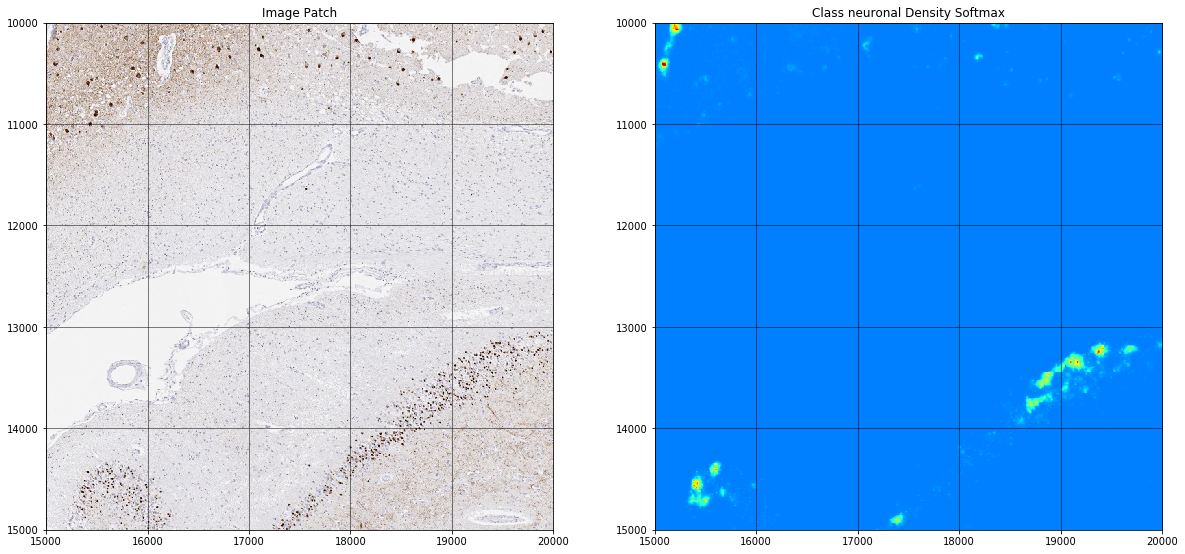

In [216]:
plot_classification_region(15000,10000,20000,15000,1,fg_class=1,sigma=0.2,show_ticks=True)

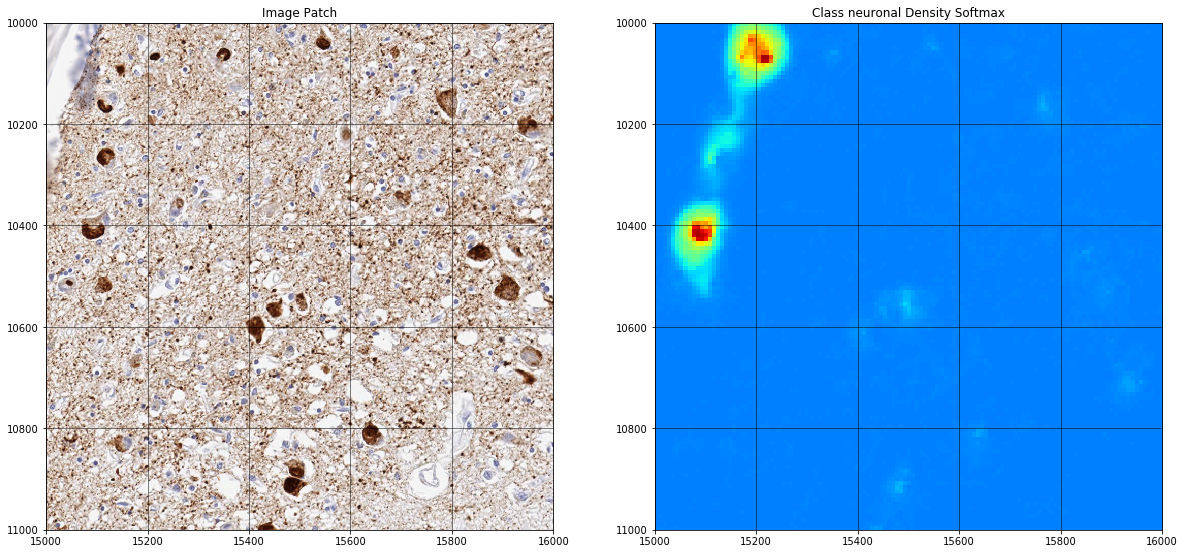

In [217]:
plot_classification_region(15000,10000,16000,11000,0,fg_class=1,sigma=0.2,show_ticks=True)